<a href="https://colab.research.google.com/github/sakagamiyoshiaki/Dataset/blob/main/Workshop_windV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise Workshop Offshore Brazil - Resource Assessment

In [1]:
# Section Wind Resource Assessment- by Yoshi (Date:23/03/2023)

# Exercise Workshop 
# 1) Plot Time series and wind rose (1 year)
# 2) Plot Weibull Distribution 
# 3) Plot Power Curve (Turbine Model)
# 4) Estimate AEP, CF
# 5) AEP Uncertainty, P90 and GF
# 6) Vertical Extrapolation - Wind Profile


In [2]:
!pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.5 MB/s eta 0:00:00


In [3]:
# Main Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#Specific Libraries
import  netCDF4 as nc4
import urllib.request
from requests import get
import ast


# 1) Plot Time Series (Wind) 

In [4]:
# 1) Plot Time series (1 year)
# ERA5 Reanalysis Dataset:  https://cds.climate.copernicus.eu/
# Format: netcdf, Period: 1 year, time resolution: 1h , 2021

# Dataset Repository 
#lat= -2.52,  lon= -41.55 (Northeast Coast - PI) - url1
#lat= -4.80,  lon= -36.85 (Northeast Coast - RN) - url2
#lat= -24.50, lon= -42.20 (Southeast Coast - RJ) - url3
#lat= -28.90, lon= -48.80 (South Coast - SC)     - url4
#lat= -30.3,  lon= -50.00 (South Coast - RS)     - url5

url1='https://github.com/sakagamiyoshiaki/Dataset/blob/main/era5_2021_series_northeast_pi.nc?raw=true'  #(Northeast PI)
url2='https://github.com/sakagamiyoshiaki/Dataset/blob/main/era5_2021_series_northeast_rn.nc?raw=true'  #(Northeast RN)
url3='https://github.com/sakagamiyoshiaki/Dataset/blob/main/era5_2021_series_southeast_rj.nc?raw=true'  #(Southeast RJ)
url4='https://github.com/sakagamiyoshiaki/Dataset/blob/main/era5_2021_series_south_sc.nc?raw=true'      #(South SC)
url5='https://github.com/sakagamiyoshiaki/Dataset/blob/main/era5_2021_series_south_rs.nc?raw=true'      #(South RS)
url=[url1,url2,url3,url4,url5]

nc_file1='era5_2021_series_northeast_pi.nc'
nc_file2='era5_2021_series_northeast_rn.nc'
nc_file3='era5_2021_series_southeast_rj.nc'
nc_file4='era5_2021_series_south_sc.nc'
nc_file5='era5_2021_series_south_rs.nc'
nc_file=[nc_file1,nc_file2,nc_file3,nc_file4,nc_file5]

#Choose site 0 (PI), 1 (RN), 2 (RJ), 3 (SC), 4 (RS)
i=2

urllib.request.urlretrieve(url[i]+nc_file[i], nc_file[i])
nc = nc4.Dataset(nc_file[i]) # open netcdf file


In [5]:
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-02-21 13:27:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data9/adaptor.mars.internal-1676985650.5376375-26596-6-6ce2ab13-7fde-436e-84c4-0643cd65950a.nc /cache/tmp/6ce2ab13-7fde-436e-84c4-0643cd65950a-adaptor.mars.internal-1676982464.446226-26596-9-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), time(8760)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 u100(time, latitude, longitude), int16 v100(time, latitude, longitude), int16 u10(time, latitude, longitude), int16 v10(time, latitude, longitude), int16 d2m(time, latitude, longitude), int16 t2m(time, latitude, longitude), int16 zust(time, latitude, longitude), int16 sst(time, latitude, longitude), int16 sp(time, latitude, longitude), int16 sshf(time, latitude, longitude)


In [6]:
# Open variables from netcdf file

u = nc.variables['u100']; v = nc.variables['v100']

# Calculate the magnitude of wind speed from u and v components
vel = np.sqrt(u[:,0,0]**2+v[:,0,0]**2)

# Calculate Normalized wind speed (correct the air density)
T = nc.variables['t2m'][:,0,0];  # Air Temperature [K]
Td = nc.variables['d2m'][:,0,0]; # Dew Point Temperature [K]
Po = nc.variables['sp'][:,0,0];  # Surface Air Pressure [Pa]

RH=(np.exp(17.625*(Td-273.15)/(243.04+Td-273.15))/np.exp(17.625*(T-273.15)/(243.04+(T-273.15))))
Pw=0.0000205*np.exp(0.0631846*T)
Rd=287;Rw=461
rho=(1/T)*((Po/Rd)-RH*Pw*(1/Rd-(1/Rw))) #air density [kg/m3]

vn=vel*(rho/1.225)**(1/3) #normalized wind 

# Create da Dataframe  (Pandas Format)
dfv=pd.DataFrame(vn,columns=['vel'])

dfv.index=pd.date_range(start='2022-01-01 00:00:00', periods=8760, freq='1h', closed='left') + pd.Timedelta(hours=-3)
dfv

<ipython-input-6-2ceaf13a7325>:23: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  dfv.index=pd.date_range(start='2022-01-01 00:00:00', periods=8760, freq='1h', closed='left') + pd.Timedelta(hours=-3)


,vel
2021-12-31 21:00:00,6.622265
2021-12-31 22:00:00,6.655241
2021-12-31 23:00:00,5.243802
2022-01-01 00:00:00,3.482260
2022-01-01 01:00:00,2.498462
...,...
2022-12-31 16:00:00,10.047802
2022-12-31 17:00:00,9.632278
2022-12-31 18:00:00,9.894859
2022-12-31 19:00:00,10.853865


<ipython-input-7-9763e0b6ce8c>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,20,2),fontsize=16)


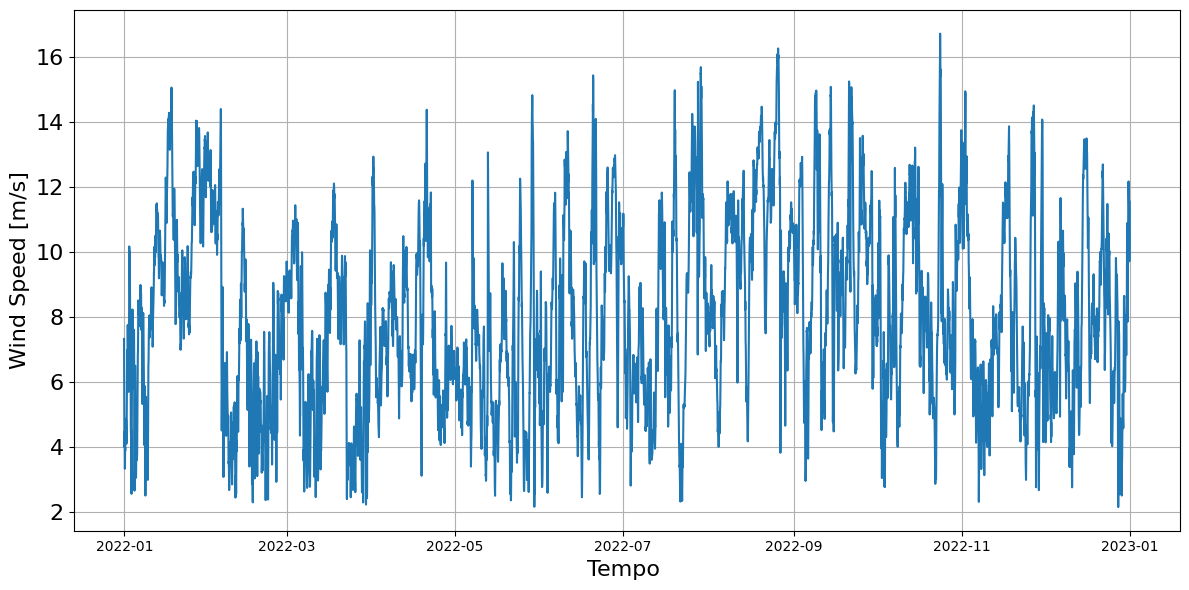

In [7]:
# Plot Time Series Wind Speed

fig, ax =plt.subplots(figsize=(12,6))
ax.plot(dfv['vel'])
ax.set_xlabel('Tempo ',fontsize=16)
ax.set_ylabel('Wind Speed [m/s]',fontsize=16)
ax.set_yticklabels(np.arange(0,20,2),fontsize=16)

plt.grid()
plt.tight_layout()

In [8]:
!pip install windrose #colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


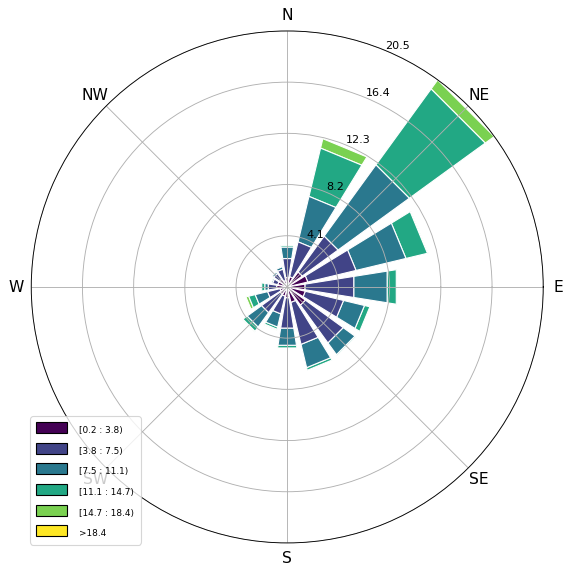

In [9]:
#Wind Rose
from windrose import WindroseAxes

def comp(x1,x2):
    y0=np.arctan(x1/x2)*180/np.pi;
    if (x1>0 and x2>0):               # Q1 - primeiro quadrante
      y=y0+180
      return y
    elif (x1<0 and x2>0):              # Q2 - segundo quadrante
      y=y0+180
      return y
    elif (x1<0 and x2<0):              # Q3 - terceiro quadrante
      y=y0
      return y 
    elif (x1>0 and x2<0):              # Q4 - quarto quadrante
      y=y0+360
      return y

DV=np.vectorize(comp); # vetorizar (calcular celula a celula), senão o IF considera toda a coluna 

dfv['dir']=DV(u[:,0,0],v[:,0,0]);

ax = WindroseAxes.from_ax()
ax.bar(dfv['dir'],dfv['vel'], normed=True, opening=0.8, edgecolor='white')
ax.set_xticklabels(['E', 'NE','N', 'NW',  'W', 'SW', 'S', 'SE'],fontsize=14) 
ax.set_legend(fontsize=14)


# 2) Weibull Distribution

In [10]:
# Plot Wind Speed Histogram (Weibull Distribution)
from scipy.stats import exponweib
from scipy.stats import weibull_min

bin=np.arange(-0.25,20,0.5) # bins of wind speed 
count=np.array(dfv['vel'].groupby([pd.cut(dfv['vel'],bin)]).count())/8760
binc=bin[:-1]+0.25

dfh=pd.DataFrame({'bins':binc, 'count':count})

loc1,shape,loc2, scale =exponweib.fit(dfv['vel'], floc=0, fa=1) # Fit Weibull Distribution
dfh['wb']=weibull_min.pdf(binc, shape, scale=scale)/2 # Calculate Freq of each bin 
dfh.index=dfh['bins']
dfh


,bins,count,wb
bins,,,
0.0,0.0,0.000228,0.000000
0.5,0.5,0.003995,0.003908
1.0,1.0,0.012557,0.009166
1.5,1.5,0.016324,0.014966
2.0,2.0,0.022945,0.020984
2.5,2.5,0.028196,0.026978
3.0,3.0,0.037329,0.032739
3.5,3.5,0.037100,0.038083
4.0,4.0,0.043836,0.042849


In [11]:
[shape,scale]

#lat= -2.52,  lon= -41.55 (Northeast Coast - PI) - shape = 4.16 , scale = 9.23 
#lat= -4.80,  lon= -36.85 (Northeast Coast - RN) - shape = 4.17 , scale = 9.28
#lat= -24.50, lon= -42.20 (Southeast Coast - RJ) - shape = 2.24 , scale = 8.61
#lat= -28.90, lon= -48.80 (South Coast - SC)     - shape = 2.05 , scale = 8.77
#lat= -30.3,  lon= -50.00 (South Coast - RS)     - shape = 2.32 , scale = 9.53


[2.239230102136285, 8.518507377667776]

<ipython-input-12-c5ab238bc5dc>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,14,2),fontsize=16)


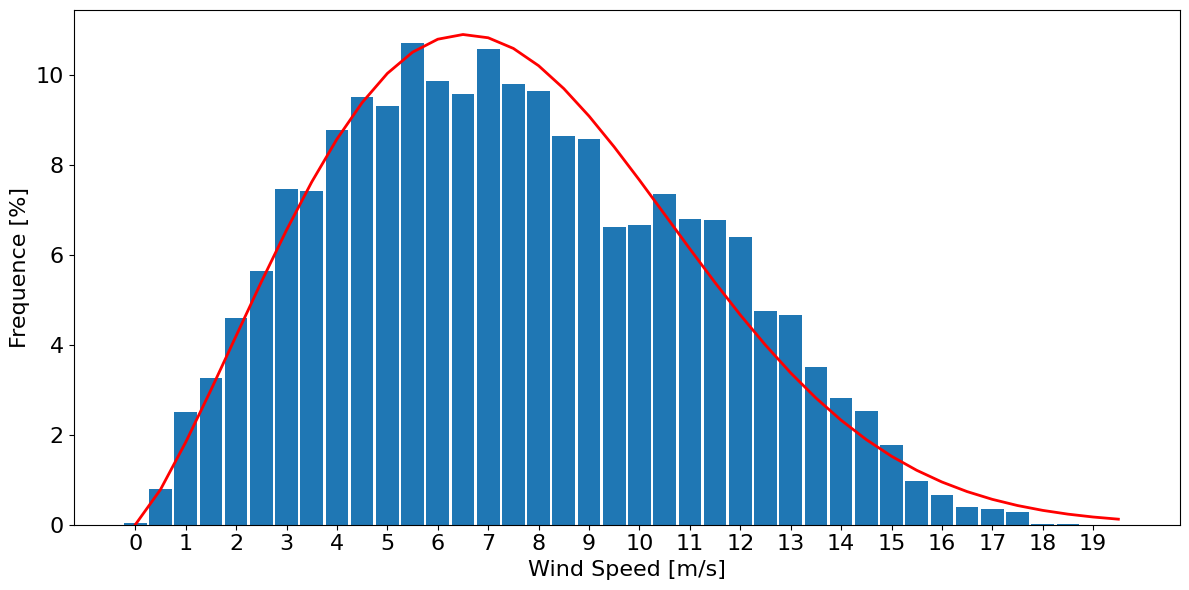

In [12]:
fig, ax =plt.subplots(figsize=(12,6))

ax.bar(binc,dfh['count']*100,width = 0.45)
ax.plot(binc,dfh['wb']*100,lw=2,c='r')

ax.set_xlabel('Wind Speed [m/s]',fontsize=16)
ax.set_ylabel('Frequence [%]',fontsize=16)

ax.set_xticks(np.arange(0,20,1))
ax.set_xticklabels(np.arange(0,20,1),fontsize=16)
ax.set_yticklabels(np.arange(0,14,2),fontsize=16)

plt.tight_layout()


#3)  Plot Power Curve

In [13]:
#Turbines Power Curve 
#!pip install windpowerlib
# Database of Turbine Models at openenergy-platform.org

from requests import get
result = get('https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows')
dft=pd.DataFrame([row for row in result.json()])
dft

,id,turbine_id,manufacturer,name,turbine_type,nominal_power,rotor_diameter,rotor_area,hub_height,max_speed_drive,...,has_power_curve,power_curve_wind_speeds,power_curve_values,has_cp_curve,power_coefficient_curve_wind_speeds,power_coefficient_curve_values,has_ct_curve,thrust_coefficient_curve_wind_speeds,thrust_coefficient_curve_values,source
0,0,1,Enercon,E-141/4200 EP 4,E-141/4200,4200,141,15613,99; 129; 135; 159,11.0,...,True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 22.0, 104.0, 260.0, 523.0, 920.0, 1471.0...",True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.29, 0.4, 0.42, 0.44, 0.45, 0.45, 0.44,...",False,None,None,https://www.enercon.de/fileadmin/Redakteur/Med...
1,1,2,Enercon,E-126/4200 EP4,E-126/4200,4200,127,12666,99; 135; 159,11.6,...,True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.0, 58.0, 185.0, 400.0, 745.0, 1200.0, ...",True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.0, 0.28, 0.37, 0.41, 0.44, 0.45, 0.45,...",False,None,None,https://www.enercon.de/fileadmin/Redakteur/Med...
2,2,3,Enercon,E-101/3500 E2,E-101/3500,3500,101,8011,74; 99,14.5,...,True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 3.0, 37.0, 116.0, 253.0, 469.0, 775.0, 1...",True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.08, 0.28, 0.37, 0.41, 0.44, 0.46, 0.47...",False,None,None,https://www.enercon.de/fileadmin/Redakteur/Med...
3,3,4,Enercon,E-115/3200,E-115/3200,3200,116,10512,92; 122; 135; 149,12.8,...,True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 3.0, 49.0, 155.0, 339.0, 628.0, 1036.0, ...",True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.06, 0.28, 0.38, 0.42, 0.45, 0.47, 0.46...",False,None,None,https://www.enercon.de/fileadmin/Redakteur/Med...
4,4,5,Enercon,E-101/3050 E2,E-101/3050,3050,101,8011,99; 124; 135; 149,14.5,...,True,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 3.0, 22.0, 49.0, 92.0, 15...",True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.076, 0.279, 0.376, 0.421, 0.452, 0.469...",False,None,None,https://www.enercon.de/fileadmin/Redakteur/Med...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,136,148,Vestas,V117-3.6,V117/3600,3600,117,10750,None,None,...,True,"[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, ...","[22.0, 78.0, 150.0, 237.0, 340.0, 466.0, 617.0...",True,"[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, ...","[0.124, 0.276, 0.356, 0.395, 0.413, 0.425, 0.4...",True,"[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, ...","[0.873, 0.849, 0.835, 0.828, 0.827, 0.825, 0.8...",http://www.windenergie-im-binnenland.de/powerc...
137,137,149,aerodyn,SCD 168 8000,SCD168/8000,8000,168,22164,None,None,...,True,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.0, 0.0, 100.0, 500.0, 1000.0, 2000.0, ...",False,None,None,False,None,None,https://www.wind-turbine-models.com/turbines/1...
138,138,150,Enercon,E-126/7500,E-126/7500,7500,127,12666,125,None,...,True,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 55.0, 110.0, 1...",False,None,None,False,None,None,https://www.thewindpower.net/turbine_en_225_en...
139,139,151,Enercon,E-126/7580,E-126/7580,7580,127,12668,127,None,...,True,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 55.0, 110.0, 1...",False,None,None,False,None,None,https://www.thewindpower.net/turbine_en_600_en...


In [14]:
#Select Wind Turbine 

# 140 IEA (IEA-15-240-RWT)
# 131 Vestas (V164/9500)
# 0 Enercon (E-141/4200)
# 1 Enercon (E-126/4200)

tb=1  # Choose one tb

import ast
vel = ast.literal_eval(dft['power_curve_wind_speeds'][tb])
pow = ast.literal_eval(dft['power_curve_values'][tb])

vel_cp= ast.literal_eval(dft['power_coefficient_curve_wind_speeds'][tb])
cp= ast.literal_eval(dft['power_coefficient_curve_values'][tb])

#vel_cp=np.ones(len(vel))*np.nan
#cp=np.ones(len(vel))*np.nan

#Fill gaps
dfp1=pd.DataFrame({'vel':vel, 'pow':pow,'vel_cp':vel_cp, 'cp':cp})
dfp1.index=np.round(dfp1['vel'].astype('float'),1)
dfp1=dfp1.loc[~dfp1.index.duplicated(keep='last')]   

dfp2=pd.DataFrame(np.arange(0,25,0.5),columns=['v_ref'])
dfp2.index=np.round(dfp2['v_ref'].astype('float'),1)

dfp=pd.concat([dfp2,dfp1],1)
dfp=dfp[~np.isnan(dfp['v_ref'])]

dfp=dfp.interpolate(method='polynomial', order=2)
dfp



<ipython-input-14-e704c21e465f>:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  dfp=pd.concat([dfp2,dfp1],1)


,v_ref,vel,pow,vel_cp,cp
0.0,0.0,NaN,NaN,NaN,NaN
0.5,0.5,NaN,NaN,NaN,NaN
1.0,1.0,1.0,0.000000,1.0,0.000000
1.5,1.5,1.5,-7.054667,1.5,-0.045568
2.0,2.0,2.0,0.000000,2.0,0.000000
2.5,2.5,2.5,21.164002,2.5,0.136705
3.0,3.0,3.0,58.000000,3.0,0.280000
3.5,3.5,3.5,112.070653,3.5,0.345336
4.0,4.0,4.0,185.000000,4.0,0.370000
4.5,4.5,4.5,278.412081,4.5,0.391281


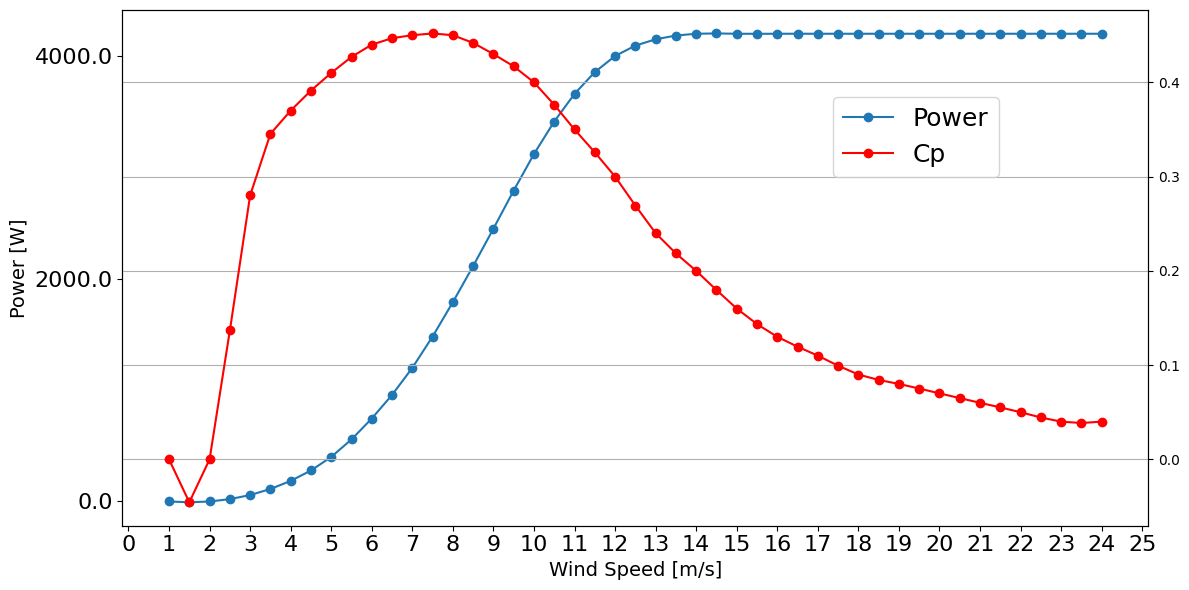

In [15]:
fig, ax =plt.subplots(figsize=(12,6))
ax.plot(dfp['vel'],dfp['pow'],'o-',label='Power')

ax2=ax.twinx()
ax2.plot(dfp['vel_cp'],dfp['cp'],'ro-',label='Cp')

ax.set_xlabel('Wind Speed [m/s]',fontsize=14)
ax.set_ylabel('Power [W]',fontsize=14)

ax.set_xticks(np.arange(0,26,1))
ax.set_xticklabels(np.arange(0,26,1),fontsize=16)
ax2.set_xticks(np.arange(0,26,1))
ax2.set_xticklabels(np.arange(0,26,1),fontsize=16)

ax.set_yticks(np.arange(0,np.max(dfp['pow']),2000))
ax.set_yticklabels(np.arange(0,np.max(dfp['pow']),2000),fontsize=16)

plt.grid()
plt.tight_layout()
fig.legend(loc=(0.7,0.7),fontsize=18)


# 4) Calculate AEP (Annual Energy Production) and Capacity Factor (CF)

In [16]:
#Calculate AEP of wind farm

df=pd.concat([dfh,dfp],axis=1) # join wind and power curve dataset

AEP=8760*np.sum(df['wb']*df['pow'])/10**6  # [GWh] , total AEP per turbine 
N=17      #Number of wind turbines
AEP=AEP*N #Total AEP of N wind turbines
AEP       #Total AEP Gross of wind farm


254.89347029493536

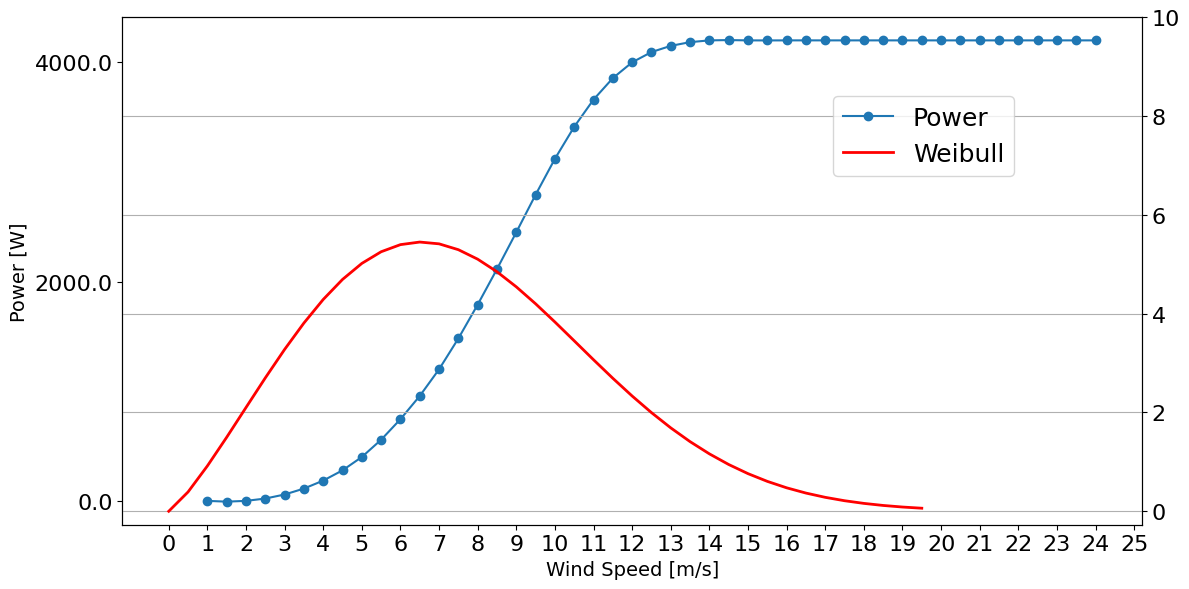

In [17]:
fig, ax =plt.subplots(figsize=(12,6))
ax.plot(df['vel'],df['pow'],'o-',label='Power')
ax.set_xlabel('Wind Speed [m/s]',fontsize=14)
ax.set_ylabel('Power [W]',fontsize=14)

ax2=ax.twinx()
ax2.plot(df['bins'],df['wb']*100,lw=2,c='r',label='Weibull')

ax.set_xticks(np.arange(0,26,1))
ax.set_xticklabels(np.arange(0,26,1),fontsize=16)
ax.set_yticks(np.arange(0,np.max(dfp['pow']),2000))
ax.set_yticklabels(np.arange(0,np.max(dfp['pow']),2000),fontsize=16)
ax2.set_yticks(np.arange(0,12,2))
ax2.set_yticklabels(np.arange(0,12,2),fontsize=16)

fig.legend(loc=(0.7,0.7),fontsize=18)

plt.grid()
plt.tight_layout()


In [18]:
#Capacity Factor
CF=AEP/(N*np.max(dfp['pow']*8760/10**6))
CF

0.40726047223310796

In [19]:
# Turbine Performance
cp_med=np.sum(df['wb']*df['cp'])
cp_med


0.35555446214023156

In [ ]:
fig, ax =plt.subplots(figsize=(12,6))
ax.plot(df['bins'],df['wb']*100,'bo-',lw=2,label='Weibull')

ax.set_xlabel('Wind Speed [m/s]',fontsize=14)
ax.set_ylabel('Frequency [%]',fontsize=14)

ax2=ax.twinx()
ax2.plot(df['vel_cp'],df['cp'],'ro-',lw=2,label='Cp')

fig.legend(loc=(0.7,0.8),fontsize=18)

plt.grid()
plt.tight_layout()


# 5) AEP Uncertainty, P90 and Garantia Física (GF)

In [ ]:
#Estimate AEP uncertainty and P50, P90

#This exercise is simplified by combining the uncertainty Category A and B across the bins (should be bin-wise)

# Corrections (systematic erros)
c1= 2    #vertical extrapolation
c2= 0    #horizontal extrapolation (complex flow)
c3= -5.5 #wake loss

# Uncertainty (random erros)
s = 5 #standard uncertainty - Category A
u1= 3 #vertical extraoplation
u2= 5 #horizontal extrapolation (complex flow)
u3= 4 #wake loss

c=(c1+c2+c3)*AEP/100 # total correction
AEPc=AEP+c #AEP net
u=(np.sqrt(s**2+ u1**2 + u2**2 + u3**2))*AEPc/100 #Combine uncertainty

U=u*2 #expanded uncertainty (95,45% for k=2 Coverage Factor)

AEPc


In [ ]:
100*u/AEPc #percentage of the uncertainty AEP

In [ ]:
#Extra: Example of uncertainty of each bin (across the bins)

#Uncertainty of the Power (0.52%*Power)
df['uc1']= 0.0052*df['pow']

#Uncertainty of the wind speed (sensibility*0.0034*wind)
df['uc2']=df['pow'].diff()/0.5*0.0034*df['vel']

#Combine uncertainty of each bin
df['uc']=np.sqrt(df['uc1']**2+df['uc2']**2)

fig, ax =plt.subplots(figsize=(12,6))

ax.plot(df['uc1'])
ax.plot(df['uc2'])
ax.plot(df['uc'])

ax.set_xlabel('Wind Speed [m/s]',fontsize=14)
ax.set_ylabel('uncertainty [kW]',fontsize=14)

plt.legend(['uc1','uc2','uc3'],loc=(0.05,0.7),fontsize=18)
plt.grid()
plt.tight_layout()


In [ ]:
# Sum the combined uncertainty weighted by the weibull frequency
uc= 8760*np.sum(df['wb']*df['uc'])/10**6 #[GW]

In [ ]:
100*N*uc/AEPc  # percentage of the uncertainty AEP [%]

In [ ]:
#Plot Gaussian Distribution of AEP and P90
fig, ax =plt.subplots(figsize=(12,6))

mu=AEPc; sigma=u;
bins=np.arange(0,AEPc*2,1)

YY=1/(sigma * np.sqrt(2*np.pi))*np.exp( - (bins - mu)**2/(2*sigma**2) ) # Gaussian Function

dfs=pd.DataFrame(bins,columns=['bins'])
dfs['pdf']=YY
dfs['cdf']=np.round(np.cumsum(YY),4)

p90=dfs[dfs['cdf']<=0.1]['bins'].iloc[-1] #Find AEP P90

ax.plot(dfs['bins'],dfs['pdf'],linewidth=2, color='b',label='pdf')
ax.fill_between(dfs['bins'],dfs['pdf'],where=dfs['bins']>p90,color='b',alpha=0.1)

ax2=ax.twinx()
ax2.plot(dfs['bins'],dfs['cdf'],linewidth=2, color='r',label='cdf')

ax.set_xlim(AEPc-u*3,AEPc+u*3)
ax.set_xlabel('AEP [GW]',fontsize=16)
ax.set_ylabel('Frequence [%]',fontsize=16)

j=len(dfs[dfs['cdf']<=0.1])
ax.scatter(dfs['bins'][j],dfs['pdf'][j],100)
ax.text(dfs['bins'][j],dfs['pdf'][j],'   P90= '+str(p90)+' GW',fontsize=20,c='b')

fig.legend(loc=(0.8,0.6),fontsize=18)

ax.grid()


In [ ]:
dfs[dfs['cdf']<=0.10]

In [ ]:
dfs[dfs['cdf']<=0.505]

In [ ]:
#Garantia Física (Portaria MME nº 101/2016) [1] - Auction Price

P90 =  p90*1000 # P90 AEP (MW), 20 years (we use only 1 year as example) 
TEIF = 0.04     # Wind Farm Maintenance Failure (2% minimum EPE [2,3])
IP   = 0.014    # Wind Farm Maintenance Preventive (Scheduled) [3] (1.4%)
dP   = 0.02*P90 # Wind Farm Loss and internal consume [3] (2%)

GF= (P90*(1-TEIF)*(1-IP)-dP)/8760 # [MWh/year]

GF

#References:
#[1] https://www.gov.br/mme/pt-br/acesso-a-informacao/legislacao/portarias/2016/portaria-n-101-2016.pdf/@@download/file/Portaria%20n%20101-2016.pdf
#[2] https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-455/Nota%20T%c3%a9cnica%20EPE_DEE_NT_044_2016_r0.pdf
#[3] https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-522/topico-545/EPE_DEE_RE_005_2022_r0.pdf


In [ ]:
#Results

#Site             Northeast        
#scale            9.28 [m/s]
#shape            4.17

#Turbine type     1        
#Power            4.1MW     
#Number of WT     17 
#Cap.Factor       51% 
#Cp_ave           0.40 

#AEP Gross        318.7 GWh    
#AEP Net          307.5 GWh    
#AEP P90          268.1 GWh
#U AEP            10.1 % 
#GF               28.3 MWh/year


# 6) Estimate Unicertainty - Vertical Extrapolation of the Wind

In [ ]:
# Impact of atmospheric stability on Wind Profile 
# Negative difference of SST and T2m results in stable condition: stratification

sst = nc.variables['sst']; tp = nc.variables['t2m']

dfm=pd.DataFrame({'sst':sst[:,0,0],'tp':tp[:,0,0]})
dfm['diff']=dfm['sst']-dfm['tp']

fig, ax =plt.subplots(figsize=(12,6))

ax.plot(dfm['diff'])

ax.set_xlabel('Time ',fontsize=16)
ax.set_ylabel('SST -T2m [°C]',fontsize=16)

ax.grid()



In [ ]:
#Period of Stratification over one year

Total=np.sum(dfm['diff']<0)*100/8760
Total


In [ ]:
#Vertical Extrapolation of Wind Profile

u = nc.variables['u100']; v = nc.variables['v100']
u10 = nc.variables['u10']; v10 = nc.variables['v10']

#Wind shear 10m to 100m - neutral condition
vel100 = np.sqrt(u[:,0,0]**2+v[:,0,0]**2)
vel10 = np.sqrt(u10[:,0,0]**2+v10[:,0,0]**2)

dfa=pd.DataFrame({'vel100':vel100,'vel10':vel10,})
dfa['alfa']=np.log(dfa['vel100']/dfa['vel10'])/np.log(100/10); #% Wind Shear

fig, ax =plt.subplots(figsize=(12,6))

ax.plot(dfa['alfa'])
ax.set_xlabel('Time ',fontsize=16)
ax.set_ylabel('Wind shear ',fontsize=16)
ax.grid()


In [ ]:
fig, ax =plt.subplots(figsize=(12,6))

ax.hist(dfa['alfa'],np.arange(0,0.2,0.01))
ax.set_xlabel('Time ',fontsize=16)
ax.set_ylabel('Wind shear ',fontsize=16)
ax.grid()


In [ ]:
dfa['vel150']=dfa['vel100']*(150/100)**dfa['alfa']

x=dfa['vel100']; y=dfa['vel150']

coef = np.polyfit(x,y,1)
f = np.poly1d(coef) 

fig, ax =plt.subplots(figsize=(12,6))
ax.scatter(dfa['vel100'],dfa['vel150'])
ax.plot(x,y, 'bo', x, f(x), '-r')

ax.set_xlabel('Vel 100m [m/s]',fontsize=16)
ax.set_ylabel('Vel 150m [m/s]',fontsize=16)

ax.grid()


In [ ]:
coef #corrections (systematic error)

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(dfa['vel150'], dfa['vel100'], squared=False)
rmse


In [ ]:
# Wind Speed extrapolation uncertainty  (randon error)
u_extrap=100*rmse/np.mean(dfa['vel150'])
u_extrap
